# Classificador de Intenções
Pré processamento de textos - comparação entre Stemming X Lemmatization

## Dataset Expandido 
 - Confusion Matrix
 - Extração de valor
   

In [1]:

import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# ===== Dataset sintético =====

df = pd.read_csv('dataset_bancario_expandido.csv')
df.rename(columns={"frase": "texto", "label": "classe"}, inplace=True)
df.head()


,texto,classe
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança
1,Gerar cobrança automática de R$ 3108,Cobrança
2,Cobrar R$ 4554 à vista amanhã,Cobrança
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança
4,Cobrar R$ 541 à vista amanhã,Cobrança


In [3]:
# Codificação das labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["classe"])
df.head()

,texto,classe,label
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança,0
1,Gerar cobrança automática de R$ 3108,Cobrança,0
2,Cobrar R$ 4554 à vista amanhã,Cobrança,0
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança,0
4,Cobrar R$ 541 à vista amanhã,Cobrança,0


## Stemming

In [4]:
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn

from nltk.corpus import mac_morpho
from nltk.stem import RSLPStemmer


nltk.download('rslp')
nltk.download('mac_morpho')
nltk.download('stopwords')


# Treinando um tagger simples com mac_morpho
train_data = mac_morpho.tagged_sents()
#print(train_data)
tagger = nltk.UnigramTagger(train_data)
print(train_data)
# StopWords
stopwords_pt = set(stopwords.words('portuguese'))

stemmer = RSLPStemmer()

# to lower case
df['texto_tratado'] = df['texto'].str.lower()

for index, entry in enumerate(df['texto_tratado']):
    tokens = nltk.word_tokenize(entry, language='portuguese') 
    tagged = tagger.tag(tokens)  	
    #print(tagged)
    final_words = []
    for word, tag in tagged:
        if word not in stopwords_pt and word.isalpha():
            final_words.append(stemmer.stem(word))

    df.loc[index, 'texto_final_stem'] = ' '.join(final_words)


[nltk_data] Downloading package rslp to
[nltk_data]     /Users/felipemenezes/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package mac_morpho to
[nltk_data]     /Users/felipemenezes/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felipemenezes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]


In [5]:
df[df['label'] == 1].head()

,texto,classe,label,texto_tratado,texto_final_stem
1000,Verificar saldo em conta conjunta,Consulta Saldo,1,verificar saldo em conta conjunta,verific sald cont conjunt
1001,Consultar saldo atualizado,Consulta Saldo,1,consultar saldo atualizado,consult sald atual
1002,Consultar saldo atualizado,Consulta Saldo,1,consultar saldo atualizado,consult sald atual
1003,Consultar quanto tenho no banco,Consulta Saldo,1,consultar quanto tenho no banco,consult quant banc
1004,Mostrar saldo bancário,Consulta Saldo,1,mostrar saldo bancário,mostr sald banc


In [6]:
df[df['label'] == 3].head()

,texto,classe,label,texto_tratado,texto_final_stem
500,"Pagar boleto no valor de R$ 449,52",Pagamento,3,"pagar boleto no valor de r$ 449,52",pag bolet val r
501,"Transferir R$ 3953,23 para a conta poupança",Pagamento,3,"transferir r$ 3953,23 para a conta poupança",transfer r cont poupanç
502,"Transferir R$ 1308,25 para Maria",Pagamento,3,"transferir r$ 1308,25 para maria",transfer r mar
503,Realizar transferência de R$ 4727 para Pedro,Pagamento,3,realizar transferência de r$ 4727 para pedro,realiz transfer r pedr
504,"Efetuar o pagamento da assinatura de R$ 4265,23",Pagamento,3,"efetuar o pagamento da assinatura de r$ 4265,23",efetu pag assinat r


In [7]:
# Remove duplicates 
print(df.shape)
df_stem = df.drop_duplicates(subset=['texto_final_stem'])
df_stem.shape

(2000, 5)


(48, 5)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ===== 2. Tokenização =====
vocab_size = 5000
tokenizer2 = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer2.fit_on_texts(df["texto_final_stem"])
sequences = tokenizer2.texts_to_sequences(df["texto_final_stem"])
#max_len = max(len(s) for s in sequences)  # tamanho máximo das frases
max_len = int(np.percentile([len(s) for s in sequences], 95))
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df["label"].values
#print(y)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Class weights para balancear
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# ===== Modelo LSTM =====
voc_size = len(tokenizer2.word_index) + 1
embedding_vector_features = 40 #20

model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=max_len))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
print(model.summary())

# ===== Treino =====
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=12
)

/Users/felipemenezes/Codes/pythonEnvs/machine/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-21 17:24:12.064610: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-21 17:24:12.064654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-21 17:24:12.064657: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1758486252.064704 18123234 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1758486252.064756 18123234 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 5, 40)          │         3,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,268 (86.98 KB)

 Trainable params: 22,268 (86.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15


2025-09-21 17:24:12.700786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5997 - loss: 1.1763 - val_accuracy: 1.0000 - val_loss: 0.0816
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9962 - loss: 0.0482 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 6.0694e-04
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 3.4806e-04
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 2.1219e-04
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 8.4754e-04 - val_accuracy: 1.0000 - val_loss: 1.4656e-04
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 7.6096e-

In [9]:

# ===== 7. Avaliação =====
loss, acc = model.evaluate(X_test, y_test)
print(f"\nAcurácia no teste: {acc:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 2.2652e-05

Acurácia no teste: 1.0000


In [10]:
# ===== 8. Testando previsão =====
nova_frase = ["consulte meu saldo".lower()]
nova_frase = [word_tokenize(entry, language='portuguese') for entry in nova_frase]

tagged = tagger.tag(nova_frase[0]) 
final_words = []
for word, tag in tagged:
        if word not in stopwords_pt and word.isalpha():
            final_words.append(stemmer.stem(word))

print(final_words)

seq = tokenizer2.texts_to_sequences([final_words])
padded = pad_sequences(seq, maxlen=max_len, padding='post')

# Faz predição
pred = model.predict(padded)[0] 

print(pred)

# Obtém índice da classe com maior probabilidade
classe_idx = np.argmax(pred)
prob = pred[classe_idx]

print(prob)

print("\nFrase:", nova_frase[0])
print("Classe prevista:", label_encoder.inverse_transform([classe_idx]))
print("Probabilidade:", prob)

['consult', 'sald']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
[3.7149816e-06 9.9998939e-01 5.9182257e-06 1.0127294e-06]
0.9999894

Frase: ['consulte', 'meu', 'saldo']
Classe prevista: ['Consulta Saldo']
Probabilidade: 0.9999894


In [11]:

# ==== Dataset de teste ====
dataset2 = [
    ("Pagar conta de luz", None),
    ("Trasferir R$5", None),
    ("Informe meu saldo", None),
    ("Cobra dez reais", None),
    ("me diga o meu saldo", None),
    ("passe um valor de R$50,00", None),
    ("transfirir R$3,99", None)
]
dfSample = pd.DataFrame(dataset2, columns=["texto", "classe_pred"])



In [12]:
def prever_classe(texto):
    frase_proc = word_tokenize(texto.lower(), language='portuguese')
    tagged = tagger.tag(frase_proc)
    
    final_words = [
        stemmer.stem(word) 
        for word, tag in tagged 
        if word not in stopwords_pt and word.isalpha()
    ]
    
    # Sequência → padding
    seq = tokenizer2.texts_to_sequences([final_words])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    
    # Predição
    pred = model.predict(padded, verbose=0)[0]
    classe_idx = np.argmax(pred)
    prob = pred[classe_idx]
    classe = label_encoder.inverse_transform([classe_idx])[0]
    return classe, prob


In [13]:
# ==== Preencher previsões ====
dfSample["classe_pred"] = dfSample["texto"].apply(
    lambda x: prever_classe(x)[0]
)
dfSample["probabilidade"] = dfSample["texto"].apply(
    lambda x: prever_classe(x)[1]
)

print(dfSample)

                       texto     classe_pred  probabilidade
0         Pagar conta de luz       Pagamento       0.965173
1              Trasferir R$5           Outro       0.878927
2          Informe meu saldo  Consulta Saldo       0.999966
3            Cobra dez reais        Cobrança       0.903256
4        me diga o meu saldo  Consulta Saldo       0.999966
5  passe um valor de R$50,00        Cobrança       0.999962
6          transfirir R$3,99           Outro       0.878927


## Lemmatização 

In [14]:
from nltk.stem import WordNetLemmatizer
# Lemmatization 
lemmatizer = WordNetLemmatizer()
tag_map = {
    "N": "n", "NPROP": "n", "NUM": "n", "ART": "n",
    "ADJ": "a", "PROADJ": "a",
    "V": "v", "PCP": "v",
    "ADV": "r", "ADV-KS": "r"
}
for index, entry in enumerate(df['texto_tratado']):
    tokens = nltk.word_tokenize(entry, language='portuguese') 
    tagged = tagger.tag(tokens)  	
    final_words = []
    for word, tag in tagged:
        if word not in stopwords_pt and word.isalpha():
            wn_pos = tag_map.get(tag, "n")  # default "n" (substantivo)
            lemma = lemmatizer.lemmatize(word, wn_pos)
            final_words.append(lemma.lower())
 
    df.loc[index, 'texto_final_lemm'] = ' '.join(final_words)

In [15]:
# ===== Tokenização para texto_final_lemm =====
tokenizer_lemm = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer_lemm.fit_on_texts(df["texto_final_lemm"])

sequences_lemm = tokenizer_lemm.texts_to_sequences(df["texto_final_lemm"])
max_len_lemm = int(np.percentile([len(s) for s in sequences_lemm], 95))

X_lemm = pad_sequences(sequences_lemm, maxlen=max_len_lemm, padding='post')
y_lemm = df["label"].values

# ===== Split treino/teste =====
X_train_lemm, X_test_lemm, y_train_lemm, y_test_lemm = train_test_split(
    X_lemm, y_lemm, test_size=0.3, random_state=42
)

# ===== Class weights =====
class_weights_lemm = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_lemm),
    y=y_train_lemm
)
class_weights_dict_lemm = dict(enumerate(class_weights_lemm))

# ===== Modelo LSTM =====
voc_size_lemm = len(tokenizer_lemm.word_index) + 1
embedding_vector_features_lemm = 20

model_lemm = Sequential()
model_lemm.add(Embedding(voc_size_lemm, embedding_vector_features_lemm, input_length=max_len_lemm))
model_lemm.add(Bidirectional(LSTM(100)))
model_lemm.add(Dropout(0.3))
model_lemm.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_lemm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lemm.build(input_shape=(None, max_len_lemm))
print(model_lemm.summary())

# ===== Treino =====
model_lemm.fit(
    X_train_lemm, y_train_lemm,
    validation_data=(X_test_lemm, y_test_lemm),
    epochs=15,
    batch_size=12,
    #class_weight=class_weights_dict_lemm
)

/Users/felipemenezes/Codes/pythonEnvs/machine/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5, 20)          │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        96,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,424 (388.38 KB)

 Trainable params: 99,424 (388.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5055 - loss: 1.0810 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 6.4280e-04
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 8.1941e-04 - val_accuracy: 1.0000 - val_loss: 3.7972e-04
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 5.1711e-04 - val_accuracy: 1.0000 - val_loss: 2.4157e-04
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 1.0000 - loss: 3.5760e-04 - val_accuracy: 1.0000 - val_loss: 1.7058e-04
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 1.0000 - loss: 2.6067e-04 - val_accuracy: 1.0000 - val_loss: 1.2789e-04
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - a

In [16]:
def prever_classe_lemm(texto):
    # Tokeniza
    frase_proc = nltk.word_tokenize(texto.lower(), language='portuguese')
    tagged = tagger.tag(frase_proc)
    lemmatizer = WordNetLemmatizer()
    tag_map = {
        "N": "n", "NPROP": "n", "NUM": "n", "ART": "n",
        "ADJ": "a", "PROADJ": "a",
        "V": "v", "PCP": "v",
        "ADV": "r", "ADV-KS": "r"
    }
    # Aplica lematização
    final_words_lemm = []
    for word, tag in tagged:
        if word not in stopwords_pt and word.isalpha():
            wn_pos = tag_map.get(tag, "n")  # default "n" (substantivo)
            lemma = lemmatizer.lemmatize(word, wn_pos)
            final_words.append(lemma.lower())

    # Sequência → padding (agora com tokenizer3 e max_len_lemm)
    seq = tokenizer_lemm.texts_to_sequences([final_words_lemm])
    padded = pad_sequences(seq, maxlen=max_len_lemm, padding='post')

    # Predição
    pred = model_lemm.predict(padded, verbose=0)[0]
    classe_idx = np.argmax(pred)
    prob = pred[classe_idx]
    classe = label_encoder.inverse_transform([classe_idx])[0]

    return classe, prob

In [17]:
# ==== Preencher previsões ====
dfSample["classe_pred_lemm"] = dfSample["texto"].apply(
    lambda x: prever_classe_lemm(x)[0]
)
dfSample["probabilidade_lemm"] = dfSample["texto"].apply(
    lambda x: prever_classe_lemm(x)[1]
)

print(dfSample)

                       texto     classe_pred  probabilidade classe_pred_lemm  \
0         Pagar conta de luz       Pagamento       0.965173            Outro   
1              Trasferir R$5           Outro       0.878927            Outro   
2          Informe meu saldo  Consulta Saldo       0.999966            Outro   
3            Cobra dez reais        Cobrança       0.903256            Outro   
4        me diga o meu saldo  Consulta Saldo       0.999966            Outro   
5  passe um valor de R$50,00        Cobrança       0.999962            Outro   
6          transfirir R$3,99           Outro       0.878927            Outro   

   probabilidade_lemm  
0            0.995803  
1            0.995803  
2            0.995803  
3            0.995803  
4            0.995803  
5            0.995803  
6            0.995803  


## Confusion Matrix

In [18]:
y_pred1=np.argmax(model.predict(X_test), axis=-1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

1.0

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

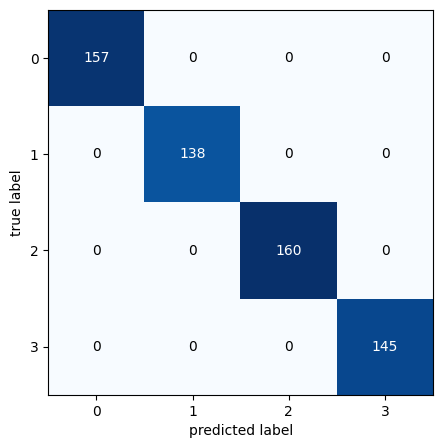

In [20]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm= confusion_matrix(y_test,y_pred1)
plot_confusion_matrix(cm, figsize=(5,5))

## Extraindo Intenção Completa 

In [21]:
import re
# Funções regex
def extrair_valor(texto):
    match = re.search(r'R\$\s?([\d\.,]+)', texto)
    if match:
        valor = match.group(1).replace('.', '').replace(',', '.')
        return float(valor)
    return None

def extrair_parcelas(texto):
    match = re.search(r'(\d+)[xX]', texto)
    if match:
        return int(match.group(1))
    return None


In [22]:
dfSample["valor"] = dfSample["texto"].apply(
    lambda x: extrair_valor(x)
)

print(dfSample)

                       texto     classe_pred  probabilidade classe_pred_lemm  \
0         Pagar conta de luz       Pagamento       0.965173            Outro   
1              Trasferir R$5           Outro       0.878927            Outro   
2          Informe meu saldo  Consulta Saldo       0.999966            Outro   
3            Cobra dez reais        Cobrança       0.903256            Outro   
4        me diga o meu saldo  Consulta Saldo       0.999966            Outro   
5  passe um valor de R$50,00        Cobrança       0.999962            Outro   
6          transfirir R$3,99           Outro       0.878927            Outro   

   probabilidade_lemm  valor  
0            0.995803    NaN  
1            0.995803   5.00  
2            0.995803    NaN  
3            0.995803    NaN  
4            0.995803    NaN  
5            0.995803  50.00  
6            0.995803   3.99  
